# UKW Marine Radio Chatter - Bridge 2 Bridge Communication
This notebook uses pretrained models to transcribe the audio files from the UKW Marine Radio Chatter - Bridge 2 Bridge Communication dataset. <br>
The dataset contains audio files and their corresponding transcriptions. Further we classify the speakers contained in the audio files.

In [1]:
import os
import IPython
import torchaudio
import torch
from pydub import AudioSegment
from pytorch_lightning.utilities.types import STEP_OUTPUT
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from src.utils import txt_to_dataframe
import numpy as np

## Configuration - Data Directories

In [2]:
class Config:
    DATA_DIR = '../data/'
    AUDIO_DIR = DATA_DIR + 'audio/'
    TEXT_DIR = DATA_DIR + 'text/'
    DATASET_DIR = 'dataset/'
    
    KAGGLE_DATA_TAG = 'linogova/marine-radio-chatter-bridge-2-bridge-communication/1'
    KAGGLE_DATA_DIR = 'Marine_audio/'

config = Config()

In [3]:
import pandas as pd

# audio_files = [d + "/" + f for d in os.listdir(config.AUDIO_DIR) for f in os.listdir(config.AUDIO_DIR + "/" + d) if f]
# text_files = [f.replace(".mp3", ".txt") for f in audio_files]
# 
# audio_files = [config.AUDIO_DIR + f for f in audio_files]
# text_files = [config.TEXT_DIR + f for f in text_files]
# 
# audio_text_files = zip(audio_files, text_files)
# audio_text_files = [(a, t) for a, t in audio_text_files if os.path.isfile(a) and os.path.isfile(t)]
# 
# df = pd.DataFrame(audio_text_files, columns=['audio_file', 'text_file'])
# df.head()

In [4]:
def convert_mp3_to_wav(in_fpath, out_fpath):
    audio = AudioSegment.from_mp3(in_fpath)
    audio = audio.set_frame_rate(16000)
    audio.export(out_fpath, format="wav")
    return out_fpath


# for index, row in df.head(2000).iterrows():
#     wav_file_path = config.DATASET_DIR + "audio/" + row['audio_file'].split("/")[-1].replace(".mp3", ".wav")
#     csv_file_path = config.DATASET_DIR + "text/" + row['text_file'].split("/")[-1].replace(".txt", ".csv")
#     if not os.path.isfile(wav_file_path):
#         convert_mp3_to_wav(row['audio_file'], wav_file_path)
#     
#         sample_df = txt_to_dataframe(row['text_file'])
#         sample_df.to_csv(csv_file_path, index=False)

In [5]:
import copy

def split_into_batches(data, max_duration=2.0):
    words = data['words']
    batches = []
    current_batch = []
    batch_start_time = words[0]['start']
    current_batch_duration = 0

    for word in words:
        word_duration = word['end'] - word['start']
        if current_batch_duration + word_duration <= max_duration:
            current_batch.append(word)
            current_batch_duration += word_duration
        else:
            if current_batch:
                batch = create_batch(data, current_batch)
                batches.append(batch)
            current_batch = [word]
            batch_start_time = word['start']
            current_batch_duration = word_duration

    if current_batch:
        batch = create_batch(data, current_batch)
        batches.append(batch)

    return batches

def create_batch(original_data, words_batch):
    batch = copy.deepcopy(original_data)
    batch['words'] = words_batch
    batch['start'] = words_batch[0]['start']
    batch['end'] = words_batch[-1]['end']
    batch['text'] = ' '.join([word['word'] for word in words_batch])
    return batch

# text_files = os.listdir(config.DATASET_DIR + "text")
# 
# for text_fpath in text_files:
#     data = pd.read_csv(config.DATASET_DIR + "text/" + text_fpath)
#     dur = data.iloc[-1]["end_time"] - data.iloc[0]["start_time"]
#     if dur < 30:
#         if len(data) < 5:
#             print(f"Data has {len(data)} less than 5 entries")
#             dur = data.iloc[-1]["end_time"] - data.iloc[0]["start_time"]
#             print(f"Duration: {dur:.2f}")
#     for i in range(len(data)):
#         if data.iloc[i]["end_time"] - data.iloc[i]["start_time"] > 30:
#             print("data is longer than 30 seconds")
        
        
            
            

In [6]:
from scipy import signal
import os
import time
import numpy as np
import pandas as pd
import torch
import torchaudio
from joblib import Parallel, delayed
from torch.utils.data import Dataset
from transformers import WhisperProcessor
from src.utils import bcolors

c = bcolors()

def batch_data(data, max_duration=30):
    batches = []
    current_batch = []
    curr_start = 0
    
    if len(data) == 0:
        return []
    
    dur = data[-1]["end_time"] - data[0]["start_time"]
    
    if dur < 10:
        return []

    for entry in data:
        if entry["end_time"] - entry['start_time'] > max_duration:
            
            continue
        if entry['end_time'] - curr_start + 0.2  > max_duration:
            if len(current_batch) == 0:
                curr_start = entry['start_time'] - 0.2
            else:
                batches.append(current_batch)
                current_batch = []
                curr_start = entry['start_time'] - 0.2

        current_batch.append(entry)

    if current_batch:
        batches.append(current_batch)

    return batches

def inner_merge_batches(data):
    return [{
        'text': ' '.join([entry['transcript'] for entry in batch]),
        'start': batch[0]['start_time'],
        'end': batch[-1]['end_time']
    } for i, batch in enumerate(data)]

def lowpass_filter(audio_data, sr):
    # Create a lowpass filter
    b, a = signal.butter(4, 1300, 'low', fs=sr)
    # Apply the lowpass filter
    filtered_audio_data = signal.filtfilt(b, a, audio_data)
    return filtered_audio_data

def apply_rms_normalization(waveform):
    rms_value = waveform.pow(2).mean().sqrt()  # Calculate RMS value of the waveform
    target_rms = 0.1  # Example target RMS value
    normalized_waveform = waveform * (target_rms / rms_value)  # Scale waveform to desired RMS value
    return normalized_waveform

class UKWFunkSprache(Dataset):
    def __init__(self, 
                 file_ids, 
                 root_dir, 
                 proc=None,
                 rms_norm=False,
                 filter_data=False,
                 n_jobs=-1):
        self.feed_ids = file_ids
        self.root_dir = root_dir
        self.processor = proc
        self.rms_norm = rms_norm
        self.filter_data = filter_data

        print(f"\n{c.OKGREEN}Preloading Samples...{c.ENDC}")
        print(f"\n{c.OKCYAN}Audio Files:         {len(self.feed_ids)}{c.ENDC}")
        print(f"{c.OKCYAN}Jobs:                {n_jobs} {c.ENDC}\n")

        start_time = time.time()
        result = Parallel(n_jobs=n_jobs)(
            delayed(self.process_file)(idx) for idx in range(len(self.feed_ids))
        )
        result = [item for sublist in result for item in sublist]
        print(f"\n{c.OKGREEN}Preloading Complete!{c.ENDC}")

        self.audio_samples = [item['audio'] for item in result]
        self.transcriptions = [item['transcript'] for item in result]
        self.groups = [item['group'] for item in result]
        
        print(f"{c.OKCYAN}Number of Samples:   {len(self.audio_samples)} {c.ENDC}\n")

        end_time = time.time()
        t = end_time - start_time
        print(f"\n{c.OKBLUE}Time taken:      {int((t - (t % 60)) / 60)} min {t % 60} sec {c.ENDC}")

    def process_file(self, idx):
        feed_id = self.feed_ids[idx]
        audio_fpath = os.path.join(self.root_dir, f"audio/{feed_id}.wav")
        text_fpath = os.path.join(self.root_dir, f"text/{feed_id}.csv")

        waveform, sample_rate = torchaudio.load(audio_fpath, channels_first=True)
        waveform = waveform.float()
        transcripts_df = pd.read_csv(text_fpath)
        
        if self.rms_norm:
            waveform = apply_rms_normalization(waveform)
        
        if self.filter_data:
            waveform = lowpass_filter(waveform, sample_rate)
        
        batches = batch_data(transcripts_df.to_dict("records"))
        if len(batches) == 0:
            return []
        
        metadata = inner_merge_batches(batches)

        sample_group = str(feed_id)
        samples = []
        for i in range(len(metadata)):
            start_time = metadata[i]['start'] - 0.2
            end_time = metadata[i]['end'] + 0.2
            transcript = metadata[i]['text']

            start_sample = int(start_time * sample_rate)
            end_sample = int(end_time * sample_rate)

            sample = waveform[:, start_sample:end_sample].squeeze()
            
            if self.processor:
                sample = self.processor.feature_extractor(sample, sampling_rate=sample_rate, return_tensors="pt").input_features.squeeze(0)
                transcript = self.processor.tokenizer(transcript, return_tensors="pt").input_ids.squeeze(0)

            samples.append({
                'group': sample_group,
                'audio': sample,
                'transcript': transcript
            })
        return samples

    def __len__(self):
        return len(self.audio_samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio = self.audio_samples[idx]
        transcript = self.transcriptions[idx]

        return {
            "input_features": audio,
            "labels": transcript
        }


# Model

In [31]:
import torchmetrics
from transformers import get_linear_schedule_with_warmup
import pytorch_lightning as pl

class WhisperLightningModule(pl.LightningModule):
    def __init__(self, model_name: str, processor, learning_rate: float, weight_decay: float, warmup_steps: int):
        super().__init__()
        self.save_hyperparameters()
        self.model = WhisperForConditionalGeneration.from_pretrained(model_name)
        self.processor = processor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.warmup_steps = warmup_steps
        
        self.wer = torchmetrics.text.wer.WordErrorRate()
        self.val_loss = []

    def forward(self, input_features, labels):
        return self.model(input_features=input_features, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self(batch["input_features"], batch["labels"])
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(batch["input_features"], batch["labels"])
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
    def test_step(self, batch, batch_idx):
        outputs = self(batch["input_features"], batch["labels"])
        loss = outputs.loss

        # Compute WER for samples in the batch
        pred_tok_ids = torch.argmax(outputs.logits, dim=-1)
        dec_preds = self.processor.batch_decode(pred_tok_ids)
        dec_labels = self.processor.batch_decode(batch["labels"])
        wer_score = wer(dec_preds, dec_labels)
        
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_wer", wer_score, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [8]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader


class SpeechDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, processor, batch_size: int, num_workers: int = 8):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.processor = processor
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=self.num_workers)

    def collate_fn(self, features):
        input_features = [feature["input_features"] for feature in features]
        batch = self.processor.feature_extractor.pad(
            [{"input_features": input_feature} for input_feature in input_features],
            return_tensors="pt"
        )

        labels = [feature["labels"] for feature in features]
        labels_batch = self.processor.tokenizer.pad(
            [{"input_ids": label} for label in labels],
            return_tensors="pt"
        )
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        if (labels[:, 0] == self.processor.tokenizer.pad_token_id).all():
            labels = labels[:, 1:]
        batch["labels"] = labels
        return batch


In [9]:
from tabulate import tabulate

def print_parameter_table(model):
    # Collect parameter information
    parameter_info = []
    total_params = 0
    # only append parameters that require gradients, if they are frozen, summarize them as well and put them at the end
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            parameter_info.append([name, param.requires_grad, num_params])

    # Print table
    headers = ["Parameter Name", "Requires Grad", "Num Params"]
    print(tabulate(parameter_info, headers=headers, tablefmt="grid"))

    # Print total number of parameters
    print(f"{c.OKBLUE}Total Parameters:      {total_params}{c.ENDC}")
    
    # Print number of trainable parameters
    print(f"{c.OKGREEN}Trainable Parameters:  {sum(p.numel() for p in model.parameters() if p.requires_grad)}{c.ENDC}")
    
    # Print number of frozen parameters
    print(f"{c.OKCYAN}Frozen Parameters:     {sum(p.numel() for p in model.parameters() if not p.requires_grad)}{c.ENDC}")

# Finetuning

In [10]:
from transformers import WhisperProcessor

model_config = {
    "model_name": "openai/whisper-tiny",
}

# Initialize the processor
processor = WhisperProcessor.from_pretrained(
    model_config["model_name"], 
    language='en', 
    task="transcribe", 
    do_normalize=True, 
    sampling_rate=16000, 
    return_tensors="pt", 
    device="cpu"
)

/home/tobias/Desktop/Uni/SS24/NLP/UKW_SpeachToText/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
model_config["filter_data"] = False
model_config["rms_norm"] = False

# Create the Datasets
feed_ids = [f.replace(".wav", "") for f in os.listdir(config.DATASET_DIR + "audio")]

ds_train = UKWFunkSprache(
    feed_ids[:1700], 
    config.DATASET_DIR, 
    proc=processor, 
    filter_data=model_config["filter_data"], 
    rms_norm=model_config["rms_norm"]
)
ds_val = UKWFunkSprache(
    feed_ids[1700:], 
    config.DATASET_DIR, 
    proc=processor, 
    filter_data=model_config["filter_data"], 
    rms_norm=model_config["rms_norm"]
)

model_config["num_train_samples"] = len(ds_train)
model_config["num_val_samples"] = len(ds_val)


Preloading Samples...

Audio Files:         1700
Jobs:                -1 


Preloading Complete!
Number of Samples:   3422 


Time taken:      1 min 46.847821950912476 sec 

Preloading Samples...

Audio Files:         300
Jobs:                -1 


Preloading Complete!
Number of Samples:   586 


Time taken:      0 min 10.213980674743652 sec 


In [20]:
from transformers import WhisperForConditionalGeneration

model_config["n_epochs"] = 4
model_config["batch_size"] = 8
model_config["learning_rate"] = 1e-4
model_config["warmup_steps"] = 600
model_config["weight_decay"] = 0.001

# Initialize DataModule
data_module = SpeechDataModule(
    ds_train, ds_val, 
    processor, 
    model_config["batch_size"]
)

# Initialize the model
model_train = WhisperLightningModule(
    model_config["model_name"], 
    processor, 
    model_config["learning_rate"], 
    model_config["weight_decay"], 
    model_config["warmup_steps"]
)
 
model_train.model = WhisperForConditionalGeneration.from_pretrained(model_config["model_name"])
model_train.model.generation_config.language = "en"
model_train.model.generation_config.task = "transcribe"
model_train.model.generation_config.is_multilingual = False
# model_train.model.generation_config.temperature = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0)

/home/tobias/Desktop/Uni/SS24/NLP/UKW_SpeachToText/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
model_config["unfreeze_encoder"] = False
model_config["unfreeze_decoder"] = True
model_config["unfreeze_linear"] = False

# Freeze layers in the encoder
for param in model_train.model.model.encoder.parameters():
    param.requires_grad = model_config["unfreeze_encoder"]

# Freeze layers in the decoder
for param in model_train.model.model.decoder.parameters():
    param.requires_grad = model_config["unfreeze_decoder"]

# Unfreeze the final linear layer for fine-tuning
model_train.model.proj_out.weight.requires_grad = model_config["unfreeze_linear"]

print_parameter_table(model_train.model)

+-------------------------------------------------------+-----------------+--------------+
| Parameter Name                                        | Requires Grad   |   Num Params |
+=======================================================+=================+==============+
| model.decoder.embed_positions.weight                  | True            |       172032 |
+-------------------------------------------------------+-----------------+--------------+
| model.decoder.layers.0.self_attn.k_proj.weight        | True            |       147456 |
+-------------------------------------------------------+-----------------+--------------+
| model.decoder.layers.0.self_attn.v_proj.weight        | True            |       147456 |
+-------------------------------------------------------+-----------------+--------------+
| model.decoder.layers.0.self_attn.v_proj.bias          | True            |          384 |
+-------------------------------------------------------+-----------------+--------------+

In [29]:
from datetime import datetime
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

model_config["n_epochs"] = 4

wandb_logger = WandbLogger(
    project="ukw-radio-trans_" + model_config["model_name"].split("/")[-1],
    log_model=False,
)
wandb_logger.experiment.config.update(model_config)

wandb_logger.log_table(key="parameters", columns=list(model_config.keys()), data=[[v for v in model_config.values()]])

# Define callbacks (like ModelCheckpoint)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="outputs/whisper-tiny/" + datetime.now().strftime("%H-%M"),
    filename="{epoch:02d}-{train_loss_epoch:.2f}-{val_loss:.2f}",
    save_top_k=2,
    mode="min"
)

# Initialize the Trainer
trainer = pl.Trainer(
    max_epochs=model_config["n_epochs"],
    callbacks=[checkpoint_callback],
    logger=wandb_logger,
    accelerator="auto",
    log_every_n_steps=5,
    num_sanity_val_steps=2,
)

# Train the model
trainer.fit(model_train, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tobias/Desktop/Uni/SS24/NLP/UKW_SpeachToText/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/tobias/Desktop/Uni/SS24/NLP/UKW_SpeachToText/outputs/whisper-tiny/16-31 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type                            | Params
----------------------------------------------------------
0 | model | WhisperForConditionalGeneration | 37.8 M
1 | wer   | WordErrorRate                   | 0     
----------------------------------------------------------
9.6 M     Trainable params
28.1 M    Non-trainable params
37.8 M    Total params
151.043   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [19]:

model_test = WhisperLightningModule.load_from_checkpoint(
    checkpoint_callback.best_model_path, 
    model_name=model_config["model_name"],
    processor=processor, 
    learning_rate=model_config["learning_rate"], 
    weight_decay=model_config["weight_decay"], 
    warmup_steps=model_config["warmup_steps"]
)

model_test.model.cuda()

# Freeze layers in the encoder
for param in model_test.model.parameters():
    param.requires_grad = False

wer_model = []
y_pred = []
y_true = []

model_test.model.eval()

for batch in data_module.val_dataloader():
    pred = model_test(batch["input_features"].to("cuda"), batch["labels"].to("cuda"))
    pred_token_ids = torch.argmax(pred.logits, dim=-1)
    decoded_labels = processor.batch_decode(batch["labels"], skip_special_tokens=True)
    decoded_preds = processor.batch_decode(pred_token_ids, skip_special_tokens=True)
    
    wer = torchmetrics.text.wer.WordErrorRate()
    wer(decoded_preds, decoded_labels)
    wer_model.append(wer.compute())
    y_pred.extend(decoded_preds)
    y_true.extend(decoded_labels)


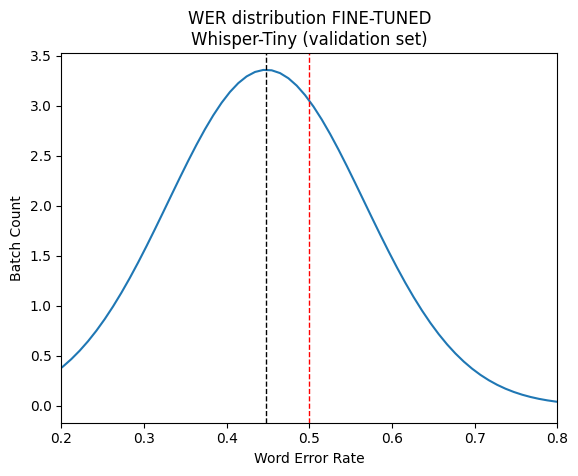

In [20]:
# plot wer distribution
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
# plot wer as normal distribution as a line plot
mean = np.mean(wer_model)
std = np.std(wer_model)
x = np.linspace(0, 1, 100)
plt.plot(x, norm.pdf(x, mean, std))

plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.5, color='r', linestyle='dashed', linewidth=1)
plt.title(f'WER distribution FINE-TUNED\nWhisper-Tiny (validation set)')
plt.xlabel('Word Error Rate')
plt.ylabel('Batch Count')
plt.xlim(0.2, 0.8)
# print the mean WER as text in the top right corner
# plt.text(0.7, 3.5, f'Mean WER: {mean:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12)
# plt.savefig('wer_distribution_tuned.png')
plt.show()


In [ ]:
from transformers import WhisperForConditionalGeneration

# Initialize DataModule
data_module = SpeechDataModule(ds_train, ds_val, processor, batch_size)

# Initialize the model
model_base = WhisperLightningModule(model_name, processor, learning_rate, weight_decay, warmup_steps)

model_base.model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")
model_base.model.generation_config.language = "en"
model_base.model.generation_config.task = "transcribe"

# Freeze layers in the encoder
for param in model_base.model.parameters():
    param.requires_grad = False

model_base.cuda()

wer_model_base = []
y_pred_base = []
y_true_base = []

for batch in data_module.val_dataloader():
    pred = model_base(batch["input_features"].to("cuda"), batch["labels"].to("cuda"))
    pred_token_ids = torch.argmax(pred.logits, dim=-1)
    decoded_labels = processor.batch_decode(batch["labels"], skip_special_tokens=True)
    decoded_preds = processor.batch_decode(pred_token_ids, skip_special_tokens=True)
    
    wer = torchmetrics.text.wer.WordErrorRate()
    wer(decoded_preds, decoded_labels)
    wer_model_base.append(wer.compute())
    y_pred_base.extend(decoded_preds)
    y_true_base.extend(decoded_labels)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np


mean_base = np.mean(wer_model_base)
std_base = np.std(wer_model_base)

x = np.linspace(0, 2*mean_base, 100)
plt.plot(x, norm.pdf(x, mean_base, std_base))

plt.axvline(mean_base, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.5, color='r', linestyle='dashed', linewidth=1)

plt.title(f'WER distribution BASE\nWhisper-Tiny (validation set)')
plt.xlabel('Word Error Rate')
plt.ylabel('Batch Count')
plt.xlim(0.2, 2*mean_base)
plt.text(1.7, 0.8, f'Mean WER: {mean:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.savefig('wer_distribution_base.png')
plt.show()